# Importación de librerías

In [ ]:
import os
import cv2
import joblib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, OneClassSVM
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from google.colab import files
from tensorflow.keras.preprocessing import image

# Definición de rutas

In [ ]:
repo_dir = '/content/Micorrizas'
# Definir rutas de las imágenes
ecto_dir = os.path.join(repo_dir, 'Imagenes/Ectomicorrizas')
endo_dir = os.path.join(repo_dir, 'Imagenes/Endomicorrizas')

# Funciones

## Cargar imagenes y Asignar etiquetas

In [ ]:
# Función para cargar imágenes y etiquetas
def cargar_img_labels(ecto_dir, endo_dir):
    images = []
    labels = []

    # Cargar imágenes de ectomicorrizas
    for nombre_img in os.listdir(ecto_dir):
        ruta_img = os.path.join(ecto_dir, nombre_img)
        img = cv2.imread(ruta_img)
        if img is not None:
            img = cv2.resize(img, (150, 150))
            images.append(img)
            labels.append(0)  # Ectomicorrizas = 0

    # Cargar imágenes de endomicorrizas
    for nombre_img in os.listdir(endo_dir):
        ruta_img = os.path.join(endo_dir, nombre_img)
        img = cv2.imread(ruta_img)
        if img is not None:
            img = cv2.resize(img, (150, 150))
            images.append(img)
            labels.append(1)  # Endomicorrizas = 1

    return np.array(images), np.array(labels)

## Segmentación de Imagenes

In [ ]:
def segmentacion_img(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh

## Extracción de Características

In [ ]:
def extraccion_caracteristicas(images):
    features = []
    for img in images:
        segmented = segmentacion_img(img)
        shape_features = cv2.HuMoments(cv2.moments(segmented)).flatten()
        color_features = cv2.mean(img)[:3]
        features.append(np.hstack((shape_features, color_features)))
    return np.array(features)

## Cargar imagen para predicción del modelo

In [ ]:
def cargar_imagen_prediccion(img_path):
  img = cv2.imread(img_path)

  if img is None:
    return None

  img = cv2.resize(img, (150, 150))
  segmented = segmentacion_img(img)
  shape_features = cv2.HuMoments(cv2.moments(segmented)).flatten()
  color_features = cv2.mean(img)[:3]
  features = np.hstack((shape_features, color_features))
  return features

# División del Conjunto de Datos  

In [ ]:
# Cargar las imágenes y etiquetas
images, labels = cargar_img_labels(ecto_dir, endo_dir)

In [ ]:
features = extraccion_caracteristicas(images)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [ ]:
print("Tamaño de X_train:", X_train.shape)
print("Tamaño de y_train:", y_train.shape)
print("Tamaño de X_test:", X_test.shape)
print("Tamaño de y_test:", y_test.shape)

Tamaño de X_train: (974, 10)
Tamaño de y_train: (974,)
Tamaño de X_test: (244, 10)
Tamaño de y_test: (244,)


# Busqueda de los mejores parámetros

In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear', 'sigmoid']
}

In [ ]:
grid_search = GridSearchCV(SVC(class_weight='balanced'), param_grid, refit=True, verbose=2)

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.3s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.4s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.3s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.3s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.3s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, k

GridSearchCV(estimator=SVC(class_weight='balanced'),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'linear', 'sigmoid']},
             verbose=2)

In [ ]:
# Obtener los mejores parámetros encontrados
best_params = grid_search.best_params_

# Imprimir los mejores parámetros
print("Mejores parámetros encontrados:", best_params)

Mejores parámetros encontrados: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


# Entrenamiento del modelo con los mejores parámetros

In [ ]:
model = SVC(**best_params, probability=True)
model.fit(X_train, y_train)

SVC(C=100, gamma=0.001, probability=True)

# Predicción y Métricas de Evaluación

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, target_names=['Ectomicorriza', 'Endomicorriza'])

In [ ]:
#Metricas de evaluacion
print(f"Accuracy: ", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_rep)

Accuracy:  0.9713114754098361
Confusion Matrix:
 [[119   0]
 [  7 118]]
Classification Report:
                precision    recall  f1-score   support

Ectomicorriza       0.94      1.00      0.97       119
Endomicorriza       1.00      0.94      0.97       125

     accuracy                           0.97       244
    macro avg       0.97      0.97      0.97       244
 weighted avg       0.97      0.97      0.97       244



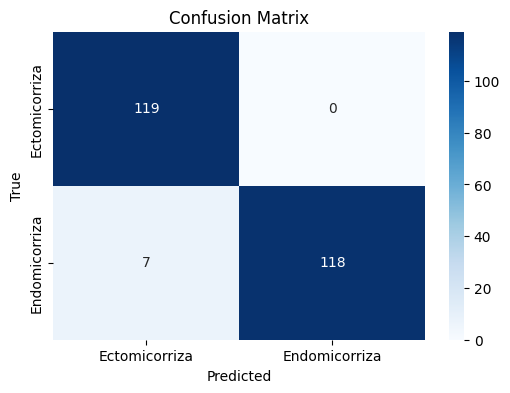

In [ ]:
# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Ectomicorriza', 'Endomicorriza'], yticklabels=['Ectomicorriza', 'Endomicorriza'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Prediccion Real

In [ ]:
import joblib

#Modelo Guardado
joblib.dump(model, '/content/drive/MyDrive/clasificacion_micorrizas.pkl')

['/content/drive/MyDrive/clasificacion_micorrizas.pkl']

In [ ]:
import cv2
import numpy as np
import joblib

# Cargar el modelo entrenado
model_svc = joblib.load('/content/drive/MyDrive/clasificacion_micorrizas.pkl')

#img_path = '/content/Micorrizas/Imagenes/Ectomicorrizas/img_ecto (208).jpg'
img_path = '/content/Micorrizas/Imagenes/Endomicorrizas/img_endo (10).jpg'
#img_path = '/content/gati.jpg'
#img_path = '/content/perro.jpg'
#img_path = '/content/avion.jpg'
#img_path = '/content/hongo.jpg'

# Cargar la imagen
imagen_procesada = cargar_imagen_prediccion(img_path)

if imagen_procesada is None:
  print(f"Error {img_path}. No existe.")

else:
  # Predicción con el modelo de clasificación
  prediction = model_svc.predict(imagen_procesada.reshape(1, -1))
  probabilities = model_svc.predict_proba(imagen_procesada.reshape(1, -1))


  if prediction[0] == 0:
    print("La imagen corresponde a una ectomicorriza.")
    print(f"prediction {prediction}")
    print(f"Probabilidad de Ectomicorriza: {probabilities}")
  elif prediction[0]==1:
    print("La imagen corresponde a una endomicorriza.")
    print(f"prediction {prediction}")
    print(f"Probabilidad de Endomicorriza: {probabilities}")

La imagen corresponde a una endomicorriza.
prediction [1]
Probabilidad de Endomicorriza: [[0.00648503 0.99351497]]
